**<참고> 교재 [자연어 처리] p.222**

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import json
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [20]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [21]:
# 전처리한 데이터 불러오기
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [22]:
# 모두 결과가 비슷하게 나오기 위해(수업 진행을 위해) seed num 부연
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [23]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))  # read binary: 2진 데이터
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))  # read: 아스키 데이터

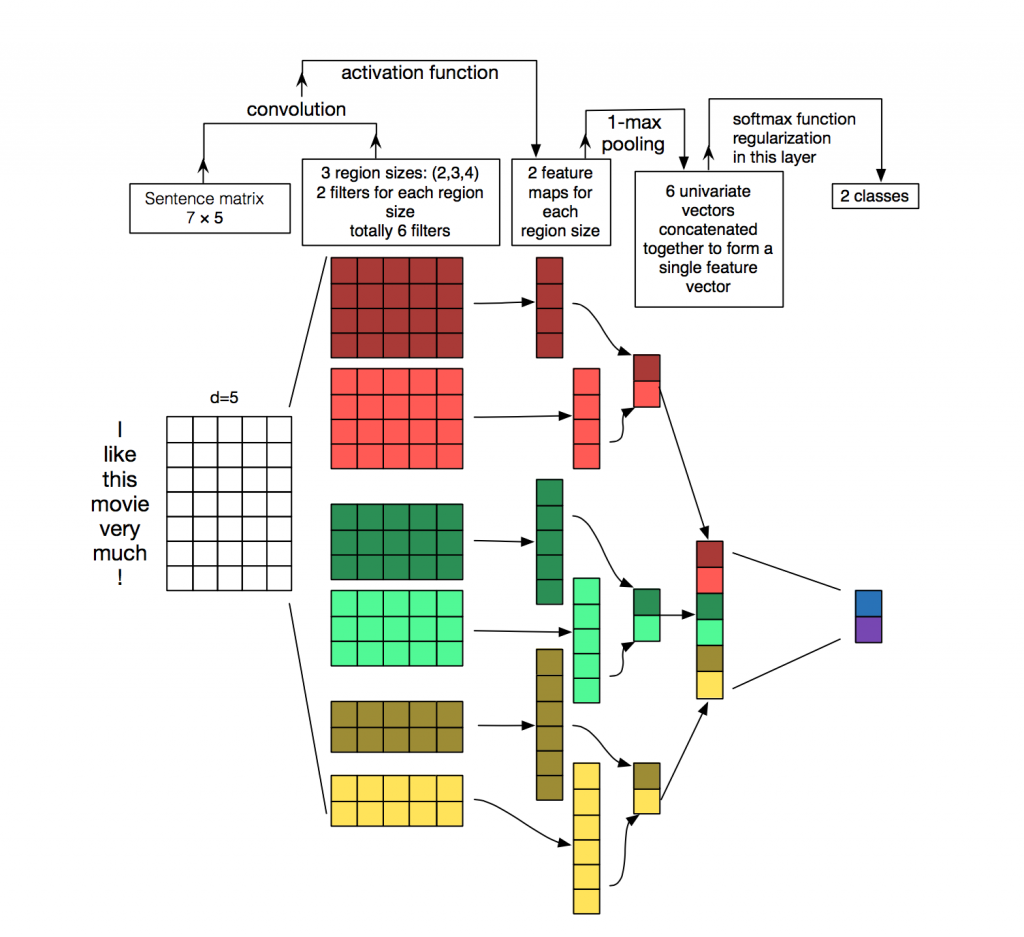

<CNN-for-sentence>
    'I like this movie very much!' 입력값이 들어옴    
    d=5 : embedded layer로 각 단어별 5차원 밀집벡터로 만듦    
    kernel : 2,3,4 각 커널별 1차원으로, 2개씩     
    각 커널을 통해 나온 각 값의 max 값 출력    
    총 6개로 쭈욱 모이고, 그후 dense층을 거쳐 결과가 나옴    
    sequentical model 불가 -> subclassing model만 가능   

In [24]:
# 모델에 필요한 hyperparameter 정의
# subclass

model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {
    'model_name': model_name,
    'vocab_size': prepro_configs['vocab_size'],
    'embedding_size': 128,  # d=5
    'num_filters': 100,  # 2,3,4 각 커널별 100개씩 존재
    'dropout_rate': 0.5,
    'hidden_dimension': 250,
    'output_deimension': 1    
}

In [28]:
# 정해진 형식
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(kargs['vocab_size']+1, kargs['embedding_size'])  # +1 안하면 에러
        self.conv_list = [
            layers.Conv1D(kargs['num_filters'], kernel_size=kernel_size,
                         padding='valid', activation='relu',    # padding='valid' 디폹여서 생략 가능
                         kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))  # 커널 크기가 최대 3을 넘지 않게
            for kernel_size in [3,4,5]
        ]
        self.pooling = layers.GlobalMaxPooling1D()  # 전체에서 Max값 추출(pool size 따로 줄 필요 없음)
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['hidden_dimension'], activation='relu',
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(kargs['output_deimension'], activation='sigmoid',
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
            
    def call(self,x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        # 각 layer 마다 pooling되어 list에 pooling 결과 3개 있음, axis=-1 맨마지막 컬럼 축 기준으로 붙여라
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [29]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# val_accuracy가 3번 연속 좋아지지 않으면(값 높아지지 않으면) stop
# 최소 min_delta만큼 좋아져아 좋아진 것으로 판단, min_delta=0이 디폴트
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)

# .h5 : 파라미터 정보만 저장, layer 정보가 있어야 불러올 수 있음
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

# save_weights_only=True : weights의 파라미터만 저장하겠다
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                                  verbose=1, save_best_only=True, save_weights_only=True)

In [36]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[early_stop, model_checkpoint])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9198
Epoch 1: val_accuracy improved from -inf to 0.81800, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 18s 68ms/step - loss: 0.1952 - accuracy: 0.9198 - val_loss: 0.4728 - val_accuracy: 0.8180
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9298
Epoch 2: val_accuracy did not improve from 0.81800
264/264 [==============================] - 18s 68ms/step - loss: 0.1736 - accuracy: 0.9298 - val_loss: 0.4921 - val_accuracy: 0.8140
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9354
Epoch 3: val_accuracy did not improve from 0.81800
264/264 [==============================] - 18s 69ms/step - loss: 0.1588 - accuracy: 0.9354 - val_loss: 0.5198 - val_accuracy: 0.8144
Epoch 4/10
264/264 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9402
Epoch 

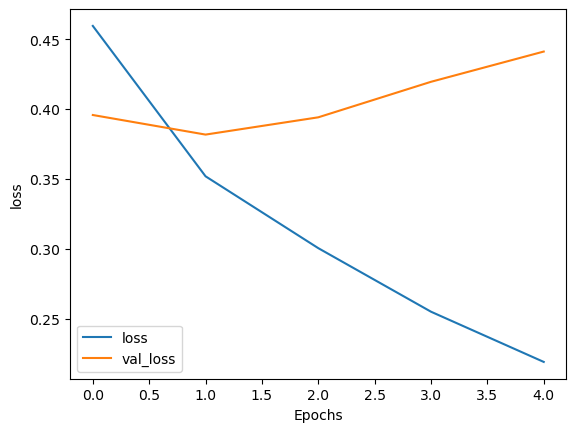

In [32]:
import matplotlib.pyplot as plt
plot_graphs(history, 'loss')
# 과대 적합 발생

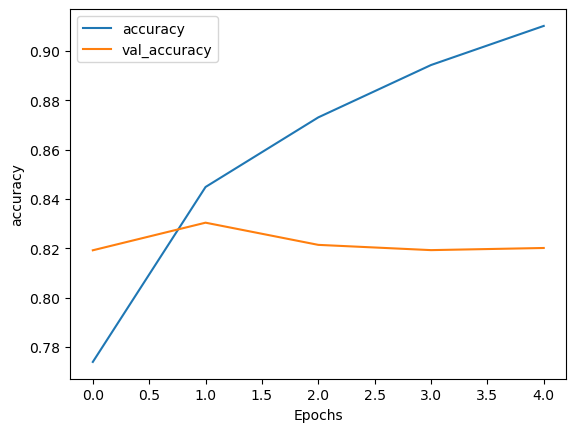

In [33]:
plot_graphs(history, 'accuracy')
# 여기서 모델은 1개 epoch정도만 실행하는 것이 적절함

In [37]:
# 변수 선언
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [42]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, 'weights.h5'))

In [43]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.4665 - accuracy: 0.8181


[0.466530442237854, 0.8180599808692932]